In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
from typing import List

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
from rdkit.Chem import PandasTools, QED, AllChem, Draw, rdFMCS
from rdkit.Chem import rdRGroupDecomposition as rdRGD

from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sascorer import calculateScore
#from cddd_preprocessing import preprocess_smiles

##### Loading original and generated molecules

In [2]:
df_input = pd.read_csv('data/original_molecules.csv')
df_input = df_input.rename(columns={'ALOGP': 'LogP'})
print('Number of AChE inhibitors: ',df_input[df_input['Target'] == 'AChE'].shape[0])
print('Number of BACE inhibitors: ',df_input[df_input['Target'] == 'BACE1'].shape[0])
print('Number of GSK3 inhibitors: ',df_input[df_input['Target'] == 'GSK3'].shape[0])

Number of AChE inhibitors:  69
Number of BACE inhibitors:  527
Number of GSK3 inhibitors:  246


In [3]:
# Generated molecules
df_AB = pd.read_csv('generated_molecules/A8B8_pool_500.csv', index_col = 0)
df_AG = pd.read_csv('generated_molecules/A8G8_pool_500.csv', index_col = 0)
df_GB = pd.read_csv('generated_molecules/G8B8_pool_500.csv', index_col = 0)

## Labelling
df_AB['Target'] = 'AB MTDL'
df_AG['Target'] = 'AG MTDL'
df_GB['Target'] = 'GB MTDL'

mapping = {}
for i, epoch in enumerate(np.unique(df_AB['epoch'])):
    mapping[epoch] = i+1
df_AB['validation_split'] = df_AB['epoch'].map(mapping)

mapping = {}
for i, epoch in enumerate(np.unique(df_AG['epoch'])):
    mapping[epoch] = i+1
df_AG['validation_split'] = df_AG['epoch'].map(mapping)

mapping = {}
for i, epoch in enumerate(np.unique(df_GB['epoch'])):
    mapping[epoch] = i+1
df_GB['validation_split'] = df_GB['epoch'].map(mapping)

In [4]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=1.5)
sns.set_style('whitegrid')

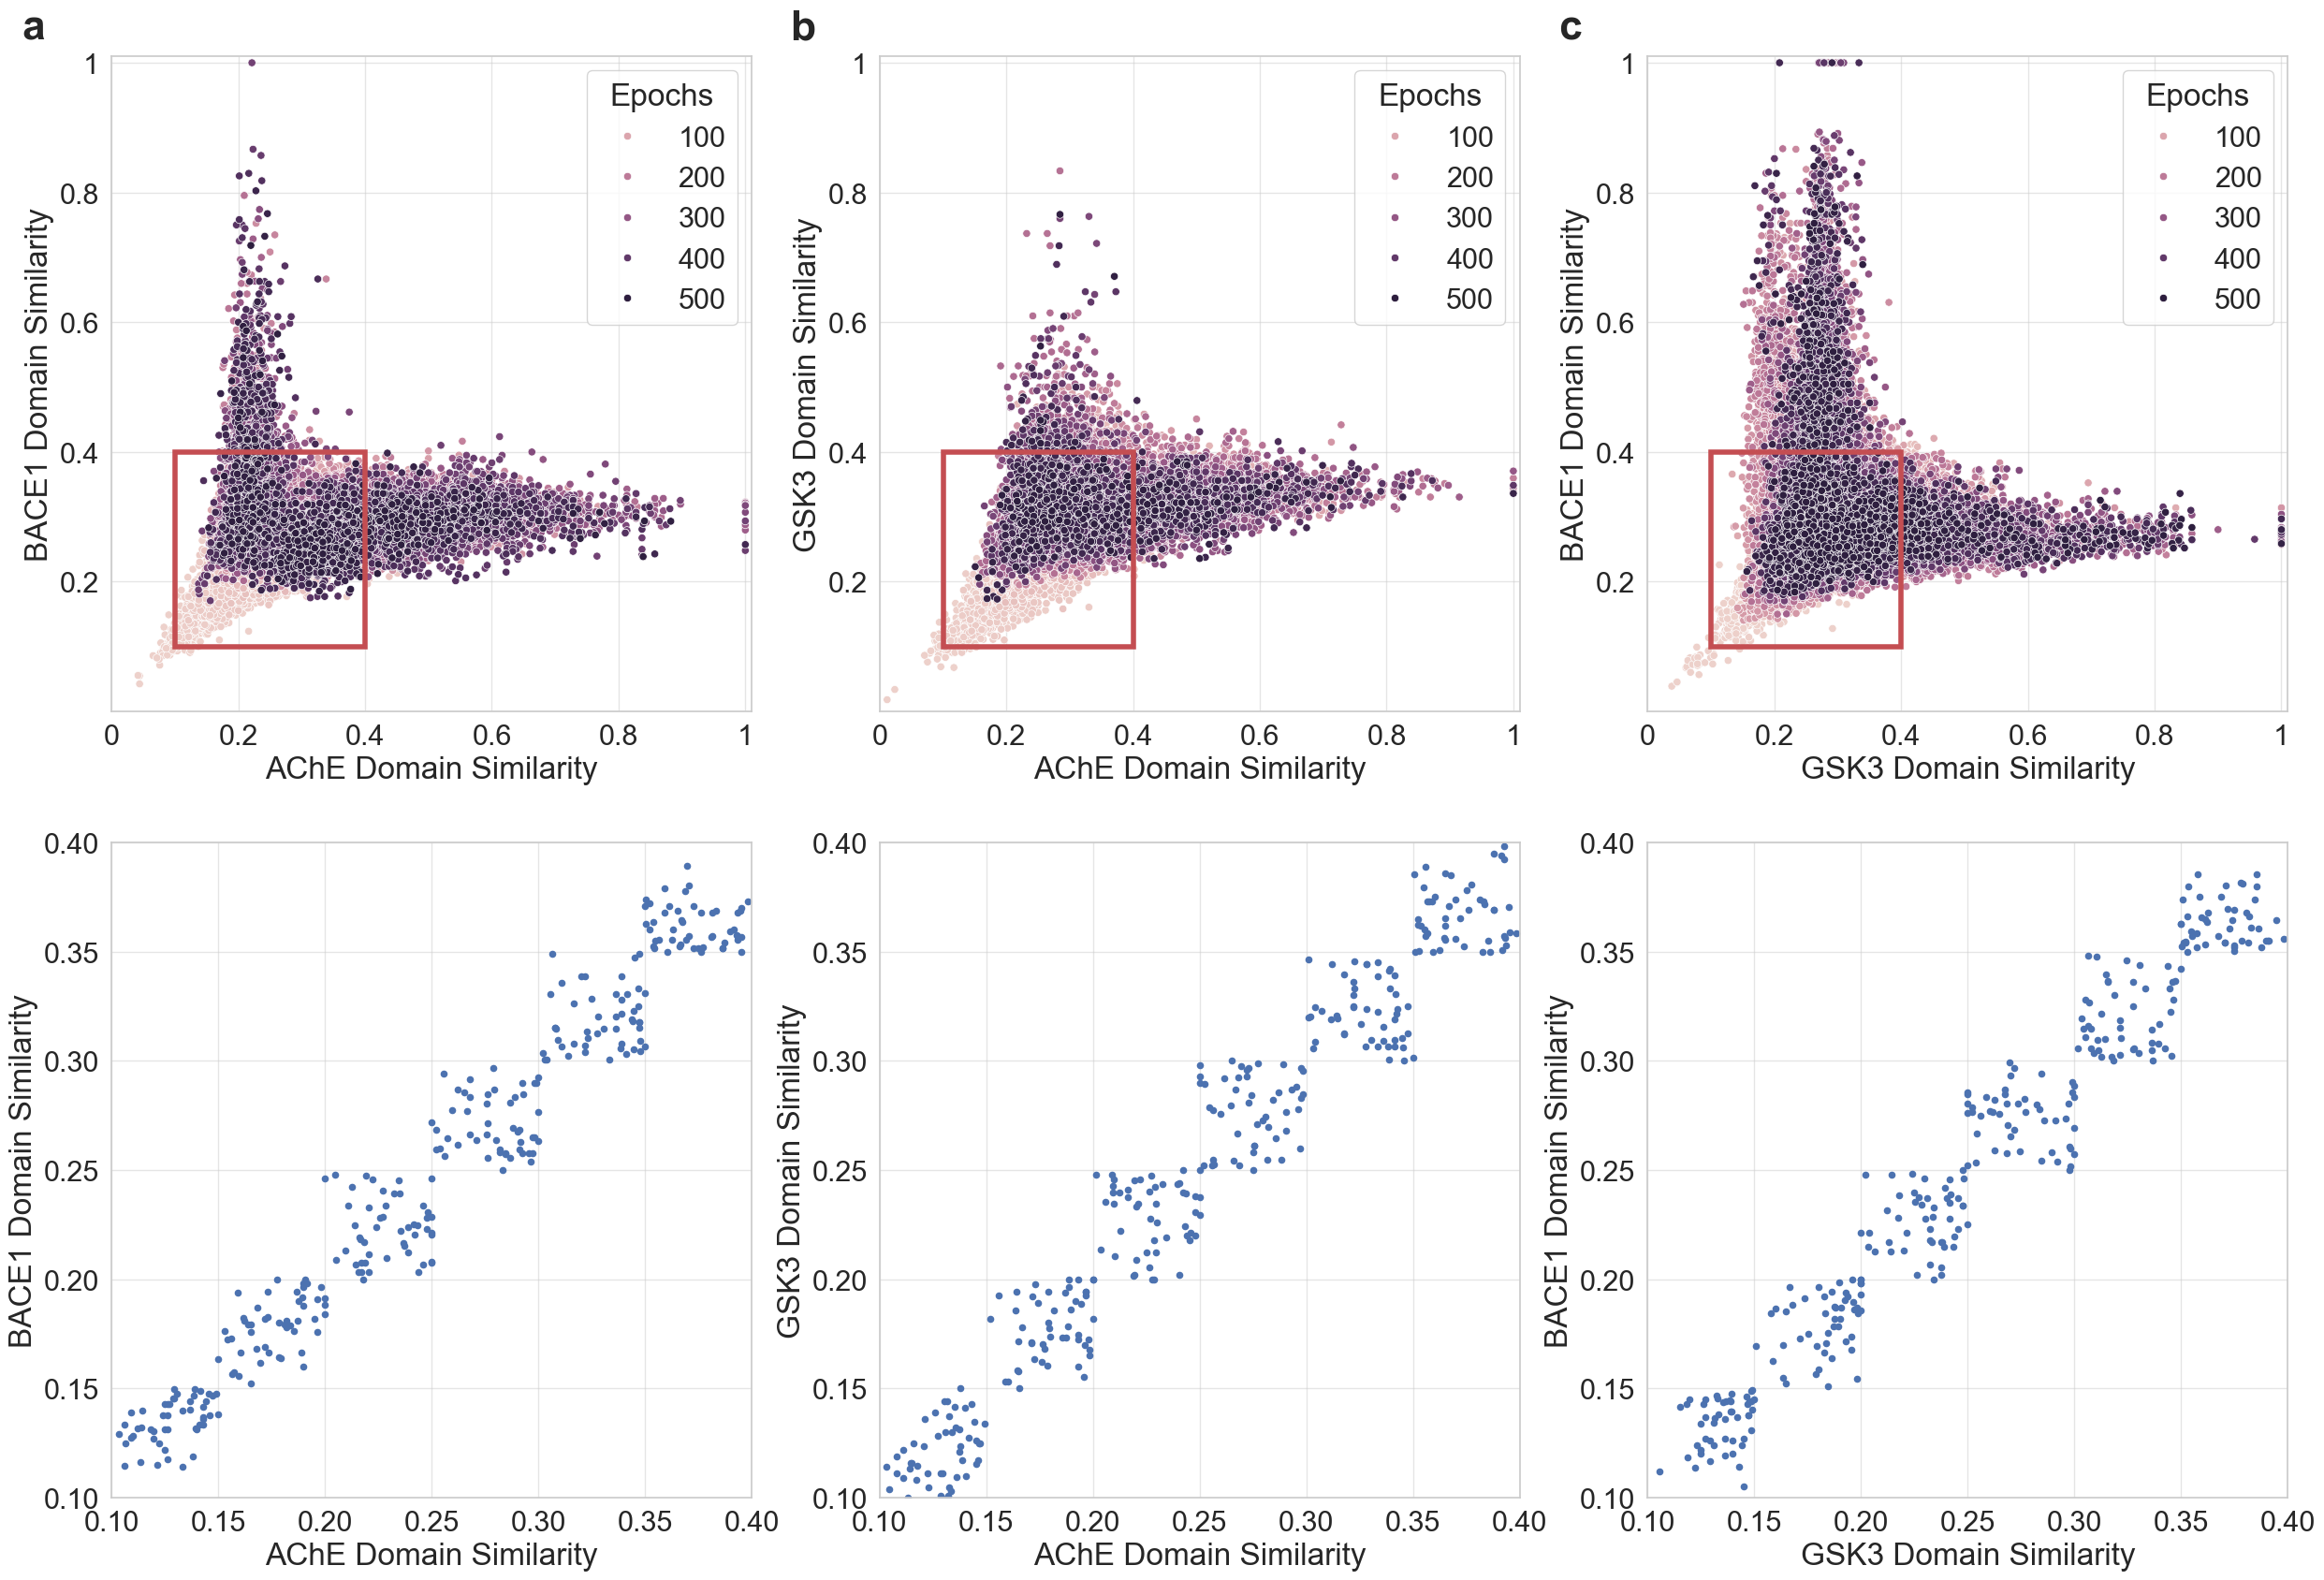

In [5]:
sns.set(rc={'figure.figsize': (10, 10)})
sns.set(font_scale=2)
sns.set_style('whitegrid')

import matplotlib.patches as patches
from matplotlib.ticker import StrMethodFormatter

fig, axes = plt.subplots(figsize = (30, 20), ncols = 3, nrows = 2)

sns.scatterplot(data = df_AB, x = 'A_score', y = 'B_score',
                hue = 'validation_split', ax = axes[0,0])

axes[0,0].set(xlabel = 'AChE Domain Similarity',
              ylabel = 'BACE1 Domain Similarity',
              #title = '52,380 unique mols from AB MTDL'
             )
axes[0,0].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axes[0,0].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
axes[0,0].set_xlim(0, 1.01)
axes[0,0].set_ylim(0, 1.01)

axes[0,0].xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
axes[0,0].yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))

axes[0,0].legend(title='Epochs')
rect = patches.Rectangle((0.1,0.1), width = 0.3, height = 0.3,
                        linewidth = 4, edgecolor = 'r', facecolor = 'none')
axes[0,0].add_patch(rect)

sns.scatterplot(data = df_AG, x = 'A_score', y = 'B_score',
                hue = 'validation_split', ax = axes[0,1])

axes[0,1].set(xlabel = 'AChE Domain Similarity',
              ylabel = 'GSK3 Domain Similarity',
              #title = '30,095 unique mols from AG MTDL'
             )
axes[0,1].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axes[0,1].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
axes[0,1].set_xlim(0, 1.01)
axes[0,1].set_ylim(0, 1.01)

axes[0,1].xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
axes[0,1].yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))

axes[0,1].legend(title='Epochs')
rect = patches.Rectangle((0.1,0.1), width = 0.3, height = 0.3,
                        linewidth = 4, edgecolor = 'r', facecolor = 'none')
axes[0,1].add_patch(rect)

sns.scatterplot(data = df_GB, x = 'A_score', y = 'B_score',
                hue = 'validation_split', ax = axes[0,2])

axes[0,2].set(xlabel = 'GSK3 Domain Similarity',
              ylabel = 'BACE1 Domain Similarity',
              #title = '136,039 unique mols from GB MTDL'
             )
axes[0,2].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
axes[0,2].set_yticks([0.2, 0.4, 0.6, 0.8, 1])
axes[0,2].set_xlim(0, 1.01)
axes[0,2].set_ylim(0, 1.01)

axes[0,2].xaxis.set_major_formatter(StrMethodFormatter('{x:g}'))
axes[0,2].yaxis.set_major_formatter(StrMethodFormatter('{x:g}'))

axes[0,2].legend(title='Epochs')
rect = patches.Rectangle((0.1,0.1), width = 0.3, height = 0.3,
                        linewidth = 4, edgecolor = 'r', facecolor = 'none')
axes[0,2].add_patch(rect)

df_AB_SAR = pd.DataFrame()
for interval in np.linspace(0.1, 0.35, 6):
    df = df_AB[(df_AB['A_score'] >= interval) & (df_AB['A_score'] <= interval+0.05)
                      &(df_AB['B_score'] >= interval) & (df_AB['B_score'] <= interval+0.05)].sample(50, random_state = 2)
    df_AB_SAR = pd.concat([df_AB_SAR, df])

df_AB_SAR.plot.scatter(x = 'A_score', y = 'B_score', ax = axes[1,0], #title = 'Interval sampling of 300 AB MTDLs',
                       xlabel = 'AChE Domain Similarity', ylabel = 'BACE1 Domain Similarity')
axes[1,0].set_xlim(0.1, 0.4)
axes[1,0].set_ylim(0.1, 0.4)


df_AG_SAR = pd.DataFrame()
for interval in np.linspace(0.1, 0.35, 6):
    df = df_AG[(df_AG['A_score'] >= interval) & (df_AG['A_score'] <= interval+0.05)
                      &(df_AG['B_score'] >= interval) & (df_AG['B_score'] <= interval+0.05)].sample(50, random_state = 2)
    df_AG_SAR = pd.concat([df_AG_SAR, df])
    
df_AG_SAR.plot.scatter(x = 'A_score', y = 'B_score', ax = axes[1,1], #title = 'Interval sampling of 300 AG MTDLs',
                       xlabel = 'AChE Domain Similarity', ylabel = 'GSK3 Domain Similarity')
axes[1,1].set_xlim(0.1, 0.4)
axes[1,1].set_ylim(0.1, 0.4)


df_GB_SAR = pd.DataFrame()
for interval in np.linspace(0.1, 0.35, 6):
    df = df_GB[(df_GB['A_score'] >= interval) & (df_GB['A_score'] <= interval+0.05)
                      &(df_GB['B_score'] >= interval) & (df_GB['B_score'] <= interval+0.05)].sample(50, random_state = 1)
    df_GB_SAR = pd.concat([df_GB_SAR, df])
    
df_GB_SAR.plot.scatter(x = 'A_score', y = 'B_score', ax = axes[1,2], #title = 'Interval sampling of 300 GB MTDLs',
                       xlabel = 'GSK3 Domain Similarity', ylabel = 'BACE1 Domain Similarity')
axes[1,2].set_xlim(0.1, 0.4)
axes[1,2].set_ylim(0.1, 0.4)

# Panel letters outside, top-left of each subplot
panel_labels = ['a', 'b', 'c']
y_offset = 0.005             # vertical gap above each axes
x_shift_frac = 0.14          # move left by 10% of each axes' width

for ax, lab in zip(axes.ravel(), panel_labels):
    bb = ax.get_position()   # figure coords
    x = max(bb.x0 - x_shift_frac * bb.width, 0.0)
    fig.text(x, bb.y1 + y_offset, lab,
             ha='left', va='bottom',
             fontsize=32, fontweight='bold')

# Thin grid lines
for ax in axes.ravel():
    ax.grid(True, linewidth=1, alpha=0.5)
    ax.set_axisbelow(True)

plt.savefig('result_fig/1docking_intervalsample', dpi=300, bbox_inches = 'tight')

/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/2823480002.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='Dataset', y='QED_score', ax=axes[0], palette="Set2")
/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/2823480002.py:31: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x='Dataset', y='SA_score', ax=axes[1], palette="Set2")
/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/2823480002.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined

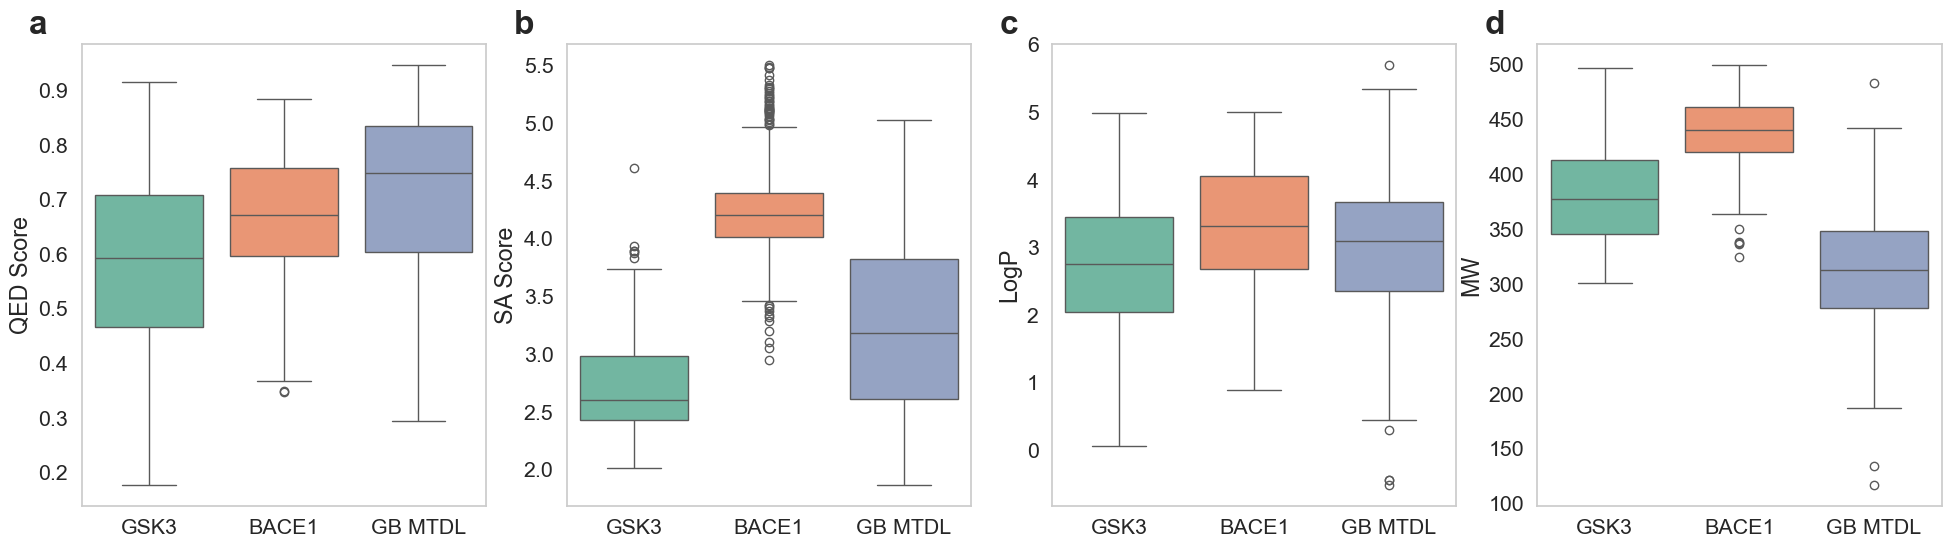

In [6]:
sns.set(rc={'figure.figsize': (16, 4)})  # wider figure for 1x4 layout
sns.set(font_scale=1.4)
sns.set_style('whitegrid')

# Filter AChE and BACE1 inhibitors from df_input
gsk3_df = df_input[df_input['Target'] == 'GSK3'].copy()
bace1_df = df_input[df_input['Target'] == 'BACE1'].copy()

# Add dataset labels
gsk3_df['Dataset'] = 'GSK3'
bace1_df['Dataset'] = 'BACE1'
df_GB_SAR['Dataset'] = 'GB MTDL'

# Combine the datasets for visualisation
properties = ['LogP', 'MW', 'QED_score', 'SA_score']
combined_df = pd.concat([
    gsk3_df[properties + ['Dataset']], 
    bace1_df[properties + ['Dataset']], 
    df_GB_SAR[properties + ['Dataset']]
])

# Create 1x4 subplots
fig, axes = plt.subplots(1, 4, figsize=(24, 6))

# QED Score
sns.boxplot(data=combined_df, x='Dataset', y='QED_score', ax=axes[0], palette="Set2")
axes[0].set_ylabel('QED Score')
axes[0].set_xlabel('')

# SA Score
sns.boxplot(data=combined_df, x='Dataset', y='SA_score', ax=axes[1], palette="Set2")
axes[1].set_ylabel('SA Score')
axes[1].set_xlabel('')

# LogP
sns.boxplot(data=combined_df, x='Dataset', y='LogP', ax=axes[2], palette="Set2")
axes[2].set_ylabel('LogP')
axes[2].set_xlabel('')

# Molecular Weight
sns.boxplot(data=combined_df, x='Dataset', y='MW', ax=axes[3], palette="Set2")
axes[3].set_ylabel('MW')
axes[3].set_xlabel('')

# Panel letters outside, top-left of each subplot
panel_labels = ['a', 'b', 'c', 'd']
y_offset = 0.005             # vertical gap above each axes
x_shift_frac = 0.13          # move left by 10% of each axes' width

for ax, lab in zip(axes.ravel(), panel_labels):
    bb = ax.get_position()   # figure coords
    x = max(bb.x0 - x_shift_frac * bb.width, 0.0)
    fig.text(x, bb.y1 + y_offset, lab,
             ha='left', va='bottom',
             fontsize=24, fontweight='bold')

# Thin grid lines
for ax in axes.ravel():
    ax.grid(True, linewidth=0, alpha=0.5)
    ax.set_axisbelow(True)

# Adjust layout
#plt.tight_layout()

plt.savefig('result_fig/GB_property', dpi=300, bbox_inches='tight')
plt.show()


In [7]:
def read_docking(result_dir, output_path = None):
    mols_txt = ""
    file_num = int(len(os.listdir(result_dir))/3)
    
    for i in range(1, file_num + 1): # Because file starts with 1
        with open(result_dir + '/lig%d_out.pdbqt' % i) as f:
            mol = f.read()
            mol = mol.split('ENDMDL')[0] # First conformation (model) which has the lowest BE
            mols_txt += mol.replace('MODEL 1', 'MODEL %d' % i) # Reindexing
            mols_txt += "ENDMDL\n"
    
    if output_path:
        with open(output_path, 'w') as f:
            f.write(mols_txt)
    
    SMILES = []
    VINA_BE = []
    
    # split mol by mol, last one is empty hence [:-1]
    for mol in mols_txt.split('ENDMDL\n')[:-1]:
        toks = mol.split('\n') # split by token
        SMILES.append(toks[2].split('Name = ')[1]) # toks[2] = smiles
        VINA_BE.append(toks[1].split()[3]) # toks[1] = vina_be
    
    df = pd.DataFrame({'SMILES': SMILES, 'VINA_BE': VINA_BE})
    df['VINA_BE'] = abs(df['VINA_BE'].astype(float))

    return df

In [8]:
df_AB_SAR = pd.DataFrame()
for interval in np.linspace(0.1, 0.35, 6):
    df = df_AB[(df_AB['A_score'] >= interval) & (df_AB['A_score'] <= interval+0.05)
                      &(df_AB['B_score'] >= interval) & (df_AB['B_score'] <= interval+0.05)].sample(50, random_state = 2)
    df_AB_SAR = pd.concat([df_AB_SAR, df])

df_AG_SAR = pd.DataFrame()
for interval in np.linspace(0.1, 0.35, 6):
    df = df_AG[(df_AG['A_score'] >= interval) & (df_AG['A_score'] <= interval+0.05)
                      &(df_AG['B_score'] >= interval) & (df_AG['B_score'] <= interval+0.05)].sample(50, random_state = 2)
    df_AG_SAR = pd.concat([df_AG_SAR, df])

df_GB_SAR = pd.DataFrame()
for interval in np.linspace(0.1, 0.35, 6):
    df = df_GB[(df_GB['A_score'] >= interval) & (df_GB['A_score'] <= interval+0.05)
                      &(df_GB['B_score'] >= interval) & (df_GB['B_score'] <= interval+0.05)].sample(50, random_state = 1)
    df_GB_SAR = pd.concat([df_GB_SAR, df])

In [9]:
lin_AB6O4W_SAR = read_docking(result_dir = 'docking/EVAL_SAR/lin_AB_6O4W')
lin_AB4IVS_SAR = read_docking(result_dir = 'docking/EVAL_SAR/lin_AB_4IVS')
lin_AB_SAR_vina = pd.merge(lin_AB6O4W_SAR, lin_AB4IVS_SAR, on = 'SMILES',
                      suffixes = ('_ACHE', '_BACE1'))

lin_AG6O4W_SAR = read_docking(result_dir = 'docking/EVAL_SAR/lin_AG_6O4W')
lin_AG6GN1_SAR = read_docking(result_dir = 'docking/EVAL_SAR/lin_AG_6GN1')
lin_AG_SAR_vina = pd.merge(lin_AG6O4W_SAR, lin_AG6GN1_SAR, on = 'SMILES',
                      suffixes = ('_ACHE', '_GSK3'))

lin_GB6GN1_SAR = read_docking(result_dir = 'docking/EVAL_SAR/lin_GB_6GN1')
lin_GB4IVS_SAR = read_docking(result_dir = 'docking/EVAL_SAR/lin_GB_4IVS')
lin_GB_SAR_vina = pd.merge(lin_GB6GN1_SAR, lin_GB4IVS_SAR, on = 'SMILES',
                      suffixes = ('_GSK3', '_BACE1'))

lin_df_AB_SAR = pd.merge(lin_AB_SAR_vina, df_AB_SAR,
                     left_on = 'SMILES', right_on = 'smiles_g').drop(columns = 'smiles_g')
lin_df_AG_SAR = pd.merge(lin_AG_SAR_vina, df_AG_SAR, 
                     left_on = 'SMILES', right_on = 'smiles_g').drop(columns = 'smiles_g')
lin_df_GB_SAR = pd.merge(lin_GB_SAR_vina, df_GB_SAR,
                     left_on = 'SMILES', right_on = 'smiles_g').drop(columns = 'smiles_g')

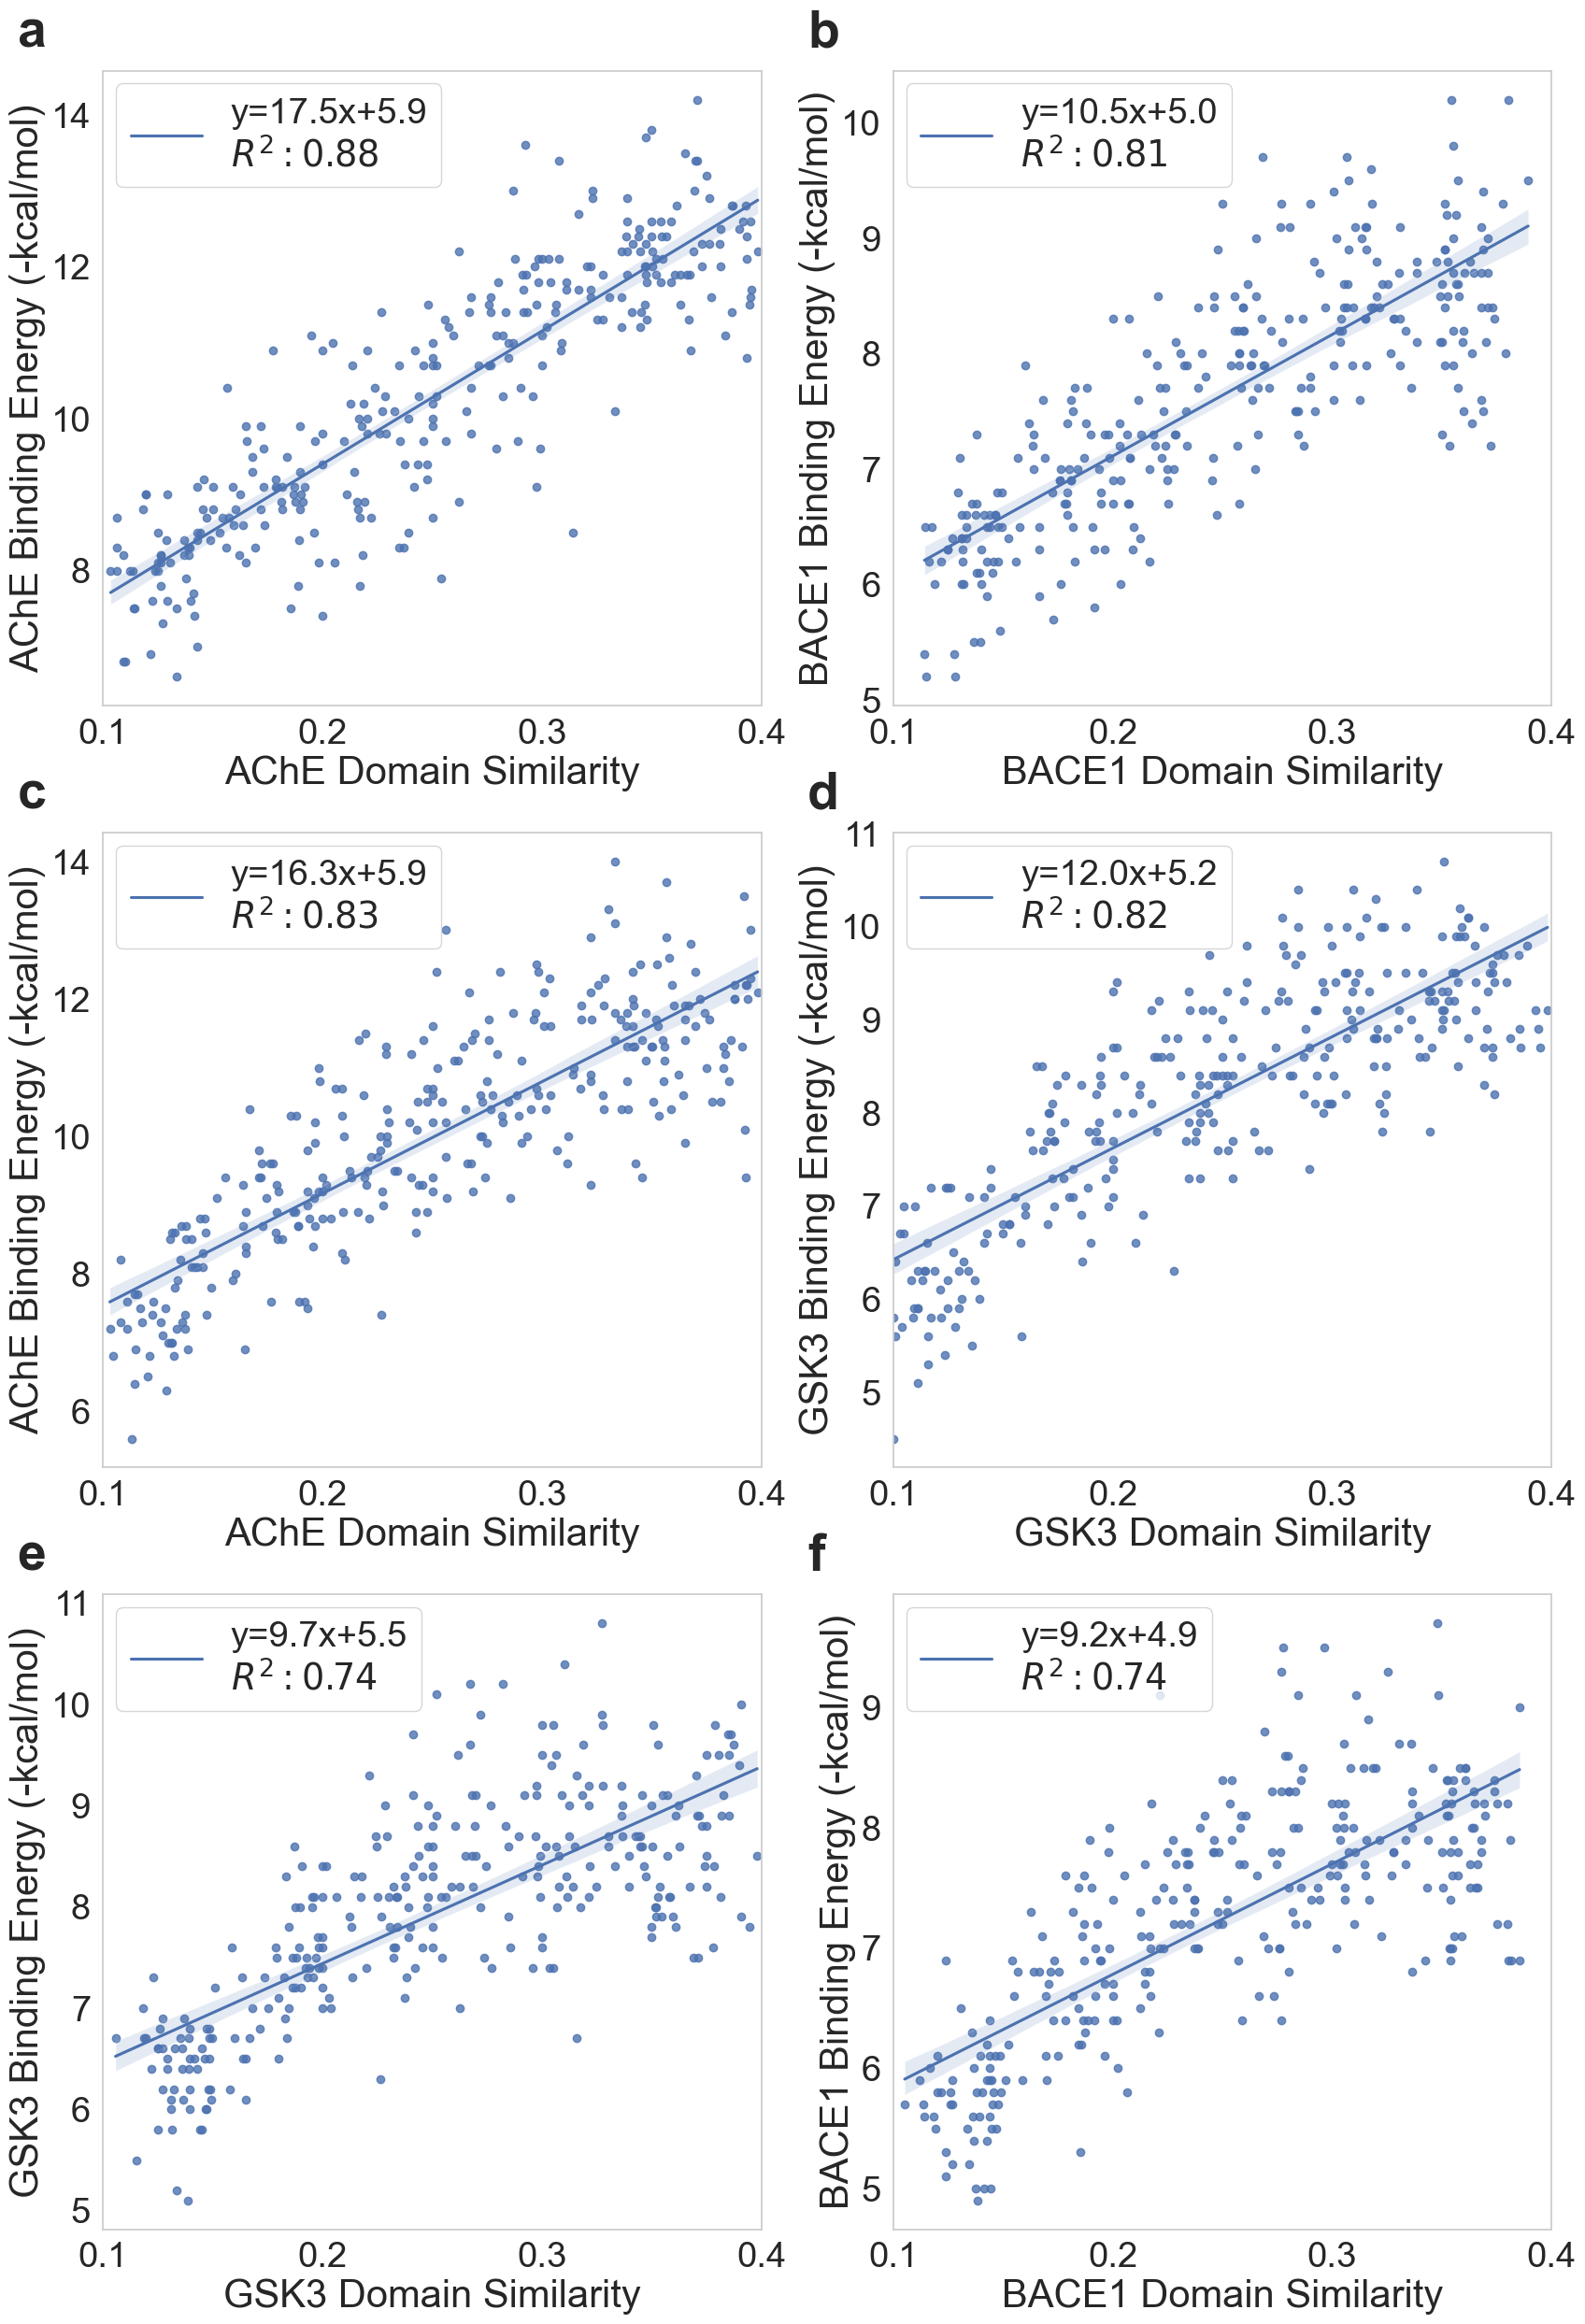

In [10]:
from scipy import stats

sns.set(font_scale=2.5)
sns.set_style('whitegrid')
fig, axes = plt.subplots(figsize = (20, 30), ncols = 2, nrows = 3)

################################ AB SAR #####################################
slope, intercept, r_value, p_value, std_err = \
stats.linregress(lin_df_AB_SAR['A_score'], lin_df_AB_SAR['VINA_BE_ACHE'])
sns.regplot(x = 'A_score', y = 'VINA_BE_ACHE',
                   data = lin_df_AB_SAR, ax = axes[0,0],
                   line_kws={'label':"y={0:.1f}x+{1:.1f}\n"
                             r"$R^2:{2:.2f}$".format(slope,intercept,r_value)})
axes[0,0].set(xlabel='AChE Domain Similarity',
      ylabel='AChE Binding Energy (-kcal/mol)',
             )
axes[0,0].legend()
axes[0,0].set_xlim(0.1, 0.4)

slope, intercept, r_value, p_value, std_err = \
stats.linregress(lin_df_AB_SAR['B_score'], lin_df_AB_SAR['VINA_BE_BACE1'])
sns.regplot(x = 'B_score', y = 'VINA_BE_BACE1',
                   data = lin_df_AB_SAR, ax = axes[0,1],
                   line_kws={'label':"y={0:.1f}x+{1:.1f}\n"
                             r"$R^2:{2:.2f}$".format(slope,intercept,r_value)})
axes[0,1].set(xlabel='BACE1 Domain Similarity',
      ylabel='BACE1 Binding Energy (-kcal/mol)',
             )
axes[0,1].legend()
axes[0,1].set_xlim(0.1, 0.4)

################################ AG SAR #####################################
slope, intercept, r_value, p_value, std_err = \
stats.linregress(lin_df_AG_SAR['A_score'], lin_df_AG_SAR['VINA_BE_ACHE'])
sns.regplot(x = 'A_score', y = 'VINA_BE_ACHE',
                   data = lin_df_AG_SAR, ax = axes[1,0],
                   line_kws={'label':"y={0:.1f}x+{1:.1f}\n"
                             r"$R^2:{2:.2f}$".format(slope,intercept,r_value)})
axes[1,0].set(xlabel='AChE Domain Similarity',
      ylabel='AChE Binding Energy (-kcal/mol)',
             )
axes[1,0].legend()
axes[1,0].set_xlim(0.1, 0.4)

slope, intercept, r_value, p_value, std_err = \
stats.linregress(lin_df_AG_SAR['B_score'], lin_df_AG_SAR['VINA_BE_GSK3'])
sns.regplot(x = 'B_score', y = 'VINA_BE_GSK3',
                   data = lin_df_AG_SAR, ax = axes[1,1],
                   line_kws={'label':"y={0:.1f}x+{1:.1f}\n"
                             r"$R^2:{2:.2f}$".format(slope,intercept,r_value)})
axes[1,1].set(xlabel='GSK3 Domain Similarity',
      ylabel='GSK3 Binding Energy (-kcal/mol)',
             )
axes[1,1].legend()
axes[1,1].set_xlim(0.1, 0.4)
    
################################ GB SAR #####################################
slope, intercept, r_value, p_value, std_err = \
stats.linregress(lin_df_GB_SAR['A_score'], lin_df_GB_SAR['VINA_BE_GSK3'])
sns.regplot(x = 'A_score', y = 'VINA_BE_GSK3',
                   data = lin_df_GB_SAR, ax = axes[2,0],
                   line_kws={'label':"y={0:.1f}x+{1:.1f}\n"
                             r"$R^2:{2:.2f}$".format(slope,intercept,r_value)})
axes[2,0].set(xlabel='GSK3 Domain Similarity',
      ylabel='GSK3 Binding Energy (-kcal/mol)',
             )
axes[2,0].legend()
axes[2,0].set_xlim(0.1, 0.4)

slope, intercept, r_value, p_value, std_err = \
stats.linregress(lin_df_GB_SAR['B_score'], lin_df_GB_SAR['VINA_BE_BACE1'])
sns.regplot(x = 'B_score', y = 'VINA_BE_BACE1',
                   data = lin_df_GB_SAR, ax = axes[2,1],
                   line_kws={'label':"y={0:.1f}x+{1:.1f}\n"
                             r"$R^2:{2:.2f}$".format(slope,intercept,r_value)})
axes[2,1].set(xlabel='BACE1 Domain Similarity',
      ylabel='BACE1 Binding Energy (-kcal/mol)',
             )
axes[2,1].legend()
axes[2,1].set_xlim(0.1, 0.4)


panel_labels = ['a', 'b', 'c', 'd', 'e', 'f']
y_offset = 0.005             # vertical gap above each axes
x_shift_frac = 0.13          # move left by 10% of each axes' width

for ax, lab in zip(axes.ravel(), panel_labels):
    bb = ax.get_position()   # figure coords
    x = max(bb.x0 - x_shift_frac * bb.width, 0.0)
    fig.text(x, bb.y1 + y_offset, lab,
             ha='left', va='bottom',
             fontsize=40, fontweight='bold')
    
# Thin grid lines
for ax in axes.ravel():
    ax.grid(True, linewidth=0, alpha=0.5)
    ax.set_axisbelow(True)
    ax.legend(loc='upper left', bbox_to_anchor=(0.02, 0.98), borderaxespad=0.0, frameon=True)

plt.savefig('result_fig/docking.png', dpi = 300, bbox_inches = 'tight')


In [11]:
from cairosvg import svg2png
from IPython.display import SVG

/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/1844597778.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Mol'] = filtered_df['SMILES'].apply(Chem.MolFromSmiles)
/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/1844597778.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Caption'] = filtered_df.apply(


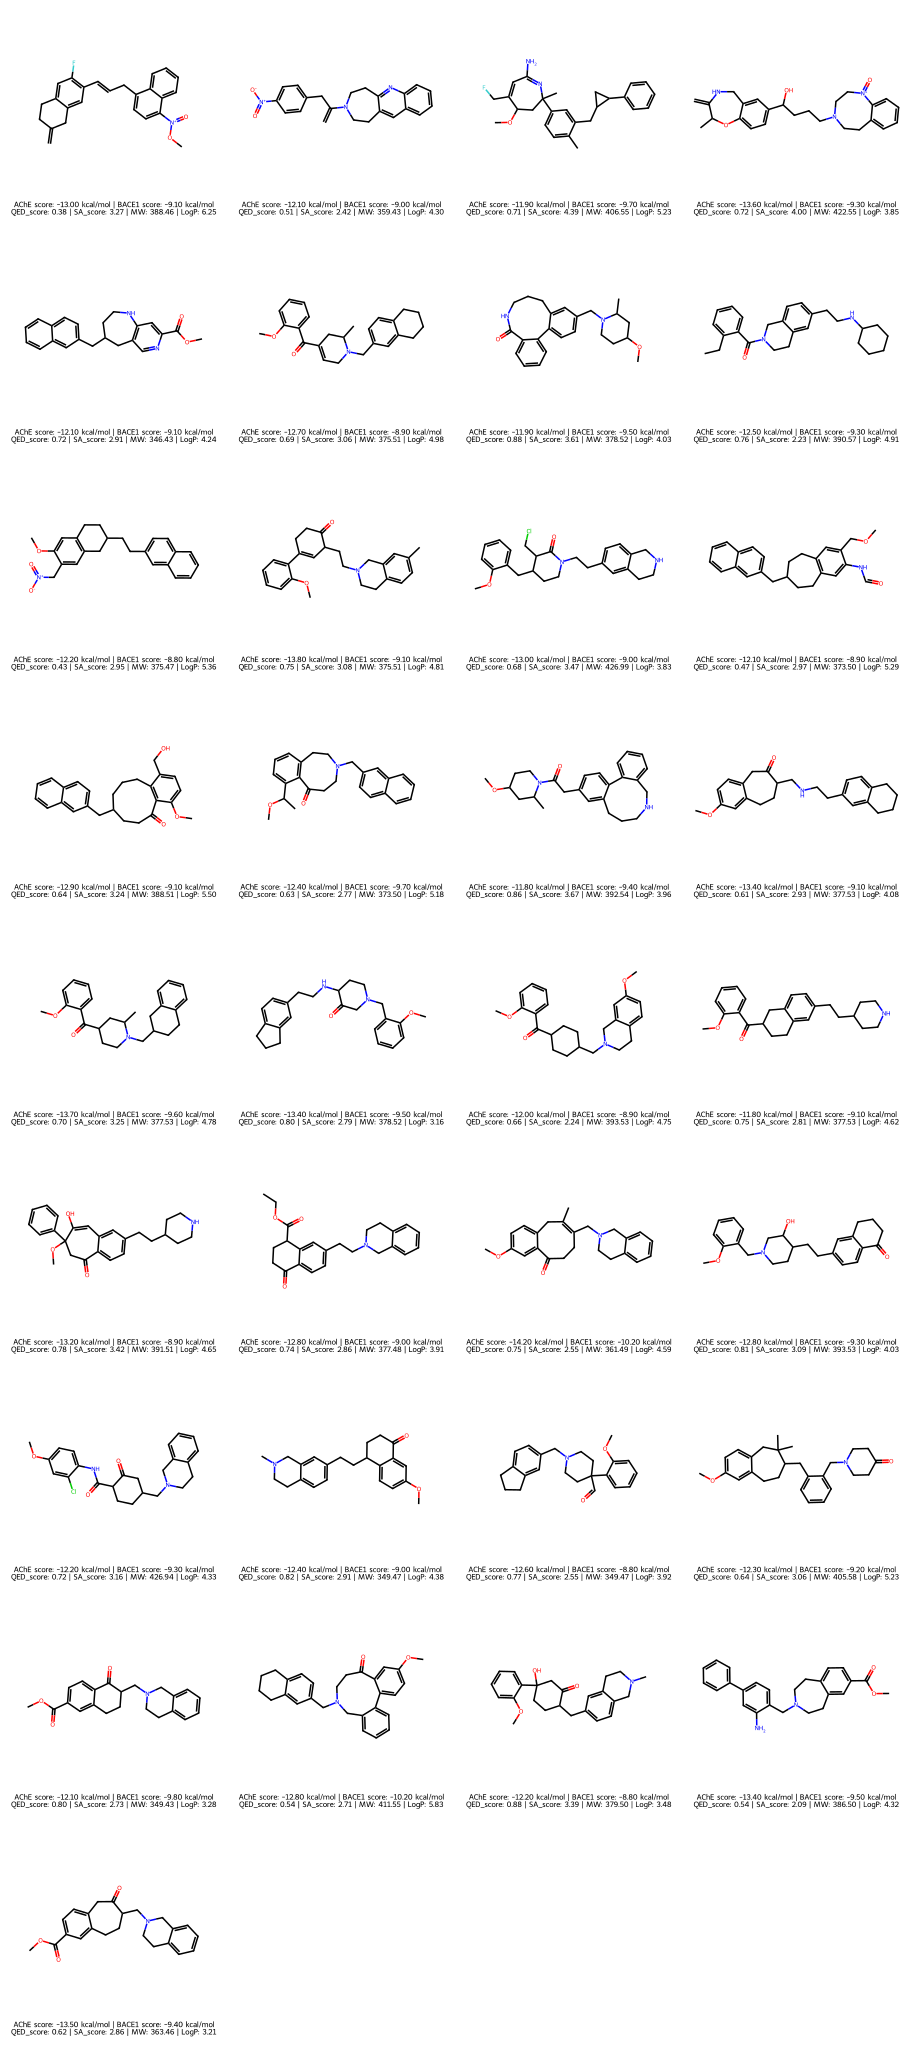

number of MTDLs higher than binding cutoff:  33


In [12]:
filtered_df = lin_df_AB_SAR[(lin_df_AB_SAR['VINA_BE_ACHE'] >= 11.8) & (lin_df_AB_SAR['VINA_BE_BACE1'] >= 8.8)]

if 'SMILES' not in filtered_df.columns:
    raise ValueError("The dataset does not contain a 'SMILES' column.")

filtered_df['Mol'] = filtered_df['SMILES'].apply(Chem.MolFromSmiles)

filtered_df['Caption'] = filtered_df.apply(
    lambda row: (
        f"AChE score: {-row['VINA_BE_ACHE']:.2f} kcal/mol | BACE1 score: {-row['VINA_BE_BACE1']:.2f} kcal/mol\n"
        f"QED_score: {row['QED_score']:.2f} | SA_score: {row['SA_score']:.2f} | MW: {row['MW']:.2f} | LogP: {row['LogP']:.2f}"
    ),
    axis=1
)

mols = filtered_df['Mol'].tolist()
captions = filtered_df['Caption'].tolist()

img = Draw.MolsToGridImage(
    mols, 
    legends=captions, 
    molsPerRow=4, 
    subImgSize=(300, 300), 
    useSVG=True  
)

svg_img = img.data.replace("font-size:12px", "font-size:16px")  # Adjust font size
display(SVG(svg_img))

png_path = "AB_hit_MTDL.png"
scale_factor = 6 
svg2png(bytestring=svg_img, write_to=png_path, output_width=1200 * scale_factor, output_height=900 * scale_factor)

print("number of MTDLs higher than binding cutoff: ", filtered_df.shape[0])
filtered_df.to_csv("AB_hit_MTDLs.csv", index = False)

In [13]:
filtered_df = lin_df_AG_SAR[(lin_df_AG_SAR['VINA_BE_ACHE'] >= 11.8) & (lin_df_AG_SAR['VINA_BE_GSK3'] >= 8.8)]

if 'SMILES' not in filtered_df.columns:
    raise ValueError("The dataset does not contain a 'SMILES' column.")

filtered_df['Mol'] = filtered_df['SMILES'].apply(Chem.MolFromSmiles)

filtered_df['Caption'] = filtered_df.apply(
    lambda row: (
        f"AChE score: {-row['VINA_BE_ACHE']:.2f} kcal/mol | GSK3 score: {-row['VINA_BE_GSK3']:.2f} kcal/mol\n"
        f"QED_score: {row['QED_score']:.2f} | SA_score: {row['SA_score']:.2f} | MW: {row['MW']:.2f} | LogP: {row['LogP']:.2f}"
    ),
    axis=1
)

mols = filtered_df['Mol'].tolist()
captions = filtered_df['Caption'].tolist()

img = Draw.MolsToGridImage(
    mols, 
    legends=captions, 
    molsPerRow=4, 
    subImgSize=(300, 300), 
    useSVG=True 
)

svg_img = img.data.replace("font-size:12px", "font-size:16px")  # Adjust font size
display(SVG(svg_img))

png_path = "AG_hit_MTDL.png"
scale_factor = 6  
svg2png(bytestring=svg_img, write_to=png_path, output_width=1200 * scale_factor, output_height=900 * scale_factor)

print("number of MTDLs higher than binding cutoff: ", filtered_df.shape[0])
filtered_df.to_csv("AG_hit_MTDLs.csv", index = False)

/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/826523624.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Mol'] = filtered_df['SMILES'].apply(Chem.MolFromSmiles)
/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/826523624.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Caption'] = filtered_df.apply(


number of MTDLs higher than binding cutoff:  43


/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/1925208109.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Mol'] = filtered_df['SMILES'].apply(Chem.MolFromSmiles)
/var/folders/4r/r_6xsstn37bbdq1sxjzshbg40000gn/T/ipykernel_29059/1925208109.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Caption'] = filtered_df.apply(


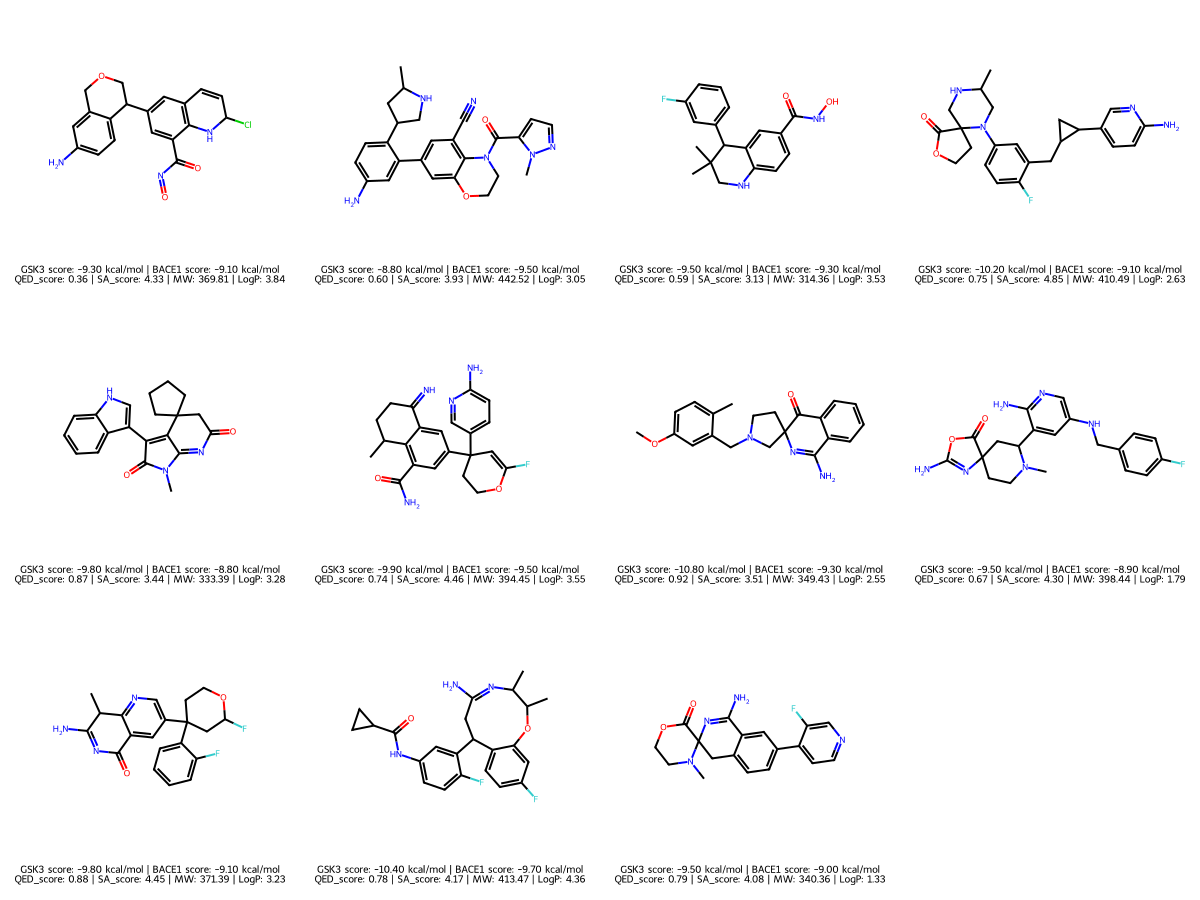

number of MTDLs higher than binding cutoff:  11


In [14]:
filtered_df = lin_df_GB_SAR[(lin_df_GB_SAR['VINA_BE_BACE1'] >= 8.8) & (lin_df_GB_SAR['VINA_BE_GSK3'] >= 8.8)]

if 'SMILES' not in filtered_df.columns:
    raise ValueError("The dataset does not contain a 'SMILES' column.")

filtered_df['Mol'] = filtered_df['SMILES'].apply(Chem.MolFromSmiles)

filtered_df['Caption'] = filtered_df.apply(
    lambda row: (
        f"GSK3 score: {-row['VINA_BE_GSK3']:.2f} kcal/mol | BACE1 score: {-row['VINA_BE_BACE1']:.2f} kcal/mol\n"
        f"QED_score: {row['QED_score']:.2f} | SA_score: {row['SA_score']:.2f} | MW: {row['MW']:.2f} | LogP: {row['LogP']:.2f}"
    ),
    axis=1
)

mols = filtered_df['Mol'].tolist()
captions = filtered_df['Caption'].tolist()

img = Draw.MolsToGridImage(
    mols, 
    legends=captions, 
    molsPerRow=4, 
    subImgSize=(300, 300), 
    useSVG=True
)

svg_img = img.data.replace("font-size:12px", "font-size:16px") 
display(SVG(svg_img))

png_path = "GB_hit_MTDL.png"
scale_factor = 3 
svg2png(bytestring=svg_img, write_to=png_path, output_width=1200 * scale_factor, output_height=900 * scale_factor)

print("number of MTDLs higher than binding cutoff: ", filtered_df.shape[0])
filtered_df.to_csv("GB_hit_MTDLs.csv", index = False)